## Customer Purchase Data : Apriori
This notebook contains recommendation methods

Import Necessary Libraries

In [37]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

In [38]:

# Load your dataset (update the filename as needed)
df = pd.read_csv("data/customer_purchases3.csv")


In [39]:
# Step 1: Transform the data into a transaction format
# One-hot encode Product Categories for each Order ID
transaction_df = df.groupby('Order ID')['Product Category'].apply(lambda x: list(set(x))).reset_index()

# Convert to a format suitable for Apriori: Each order as a row, each category as a column
categories = df['Product Category'].unique()  # Get all unique categories
encoded_df = pd.DataFrame([{cat: (cat in row) for cat in categories} for row in transaction_df['Product Category']])

# Step 2: Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(encoded_df, min_support=0.1, use_colnames=True)

# Step 3: Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Step 4: Filter rules where two or more categories are involved
filtered_rules = rules[(rules['antecedents'].apply(lambda x: len(x) >= 1)) & 
                       (rules['consequents'].apply(lambda x: len(x) >= 1))]

# Display the filtered association rules
print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                      antecedents                    consequents  support  \
0                        (Sports)                        (Books)   0.2580   
1                         (Books)                       (Sports)   0.2580   
2                (Home & Kitchen)                     (Clothing)   0.2642   
3                      (Clothing)               (Home & Kitchen)   0.2642   
4        (Home & Kitchen, Sports)                        (Books)   0.1298   
5         (Home & Kitchen, Books)                       (Sports)   0.1298   
6                        (Sports)        (Home & Kitchen, Books)   0.1298   
7                         (Books)       (Home & Kitchen, Sports)   0.1298   
8              (Sports, Clothing)                        (Books)   0.1274   
9                         (Books)             (Sports, Clothing)   0.1274   
10          (Electronics, Sports)                        (Books)   0.1310   
11           (Electronics, Books)                       (Sports)   0.1310   

Draw Network Graph

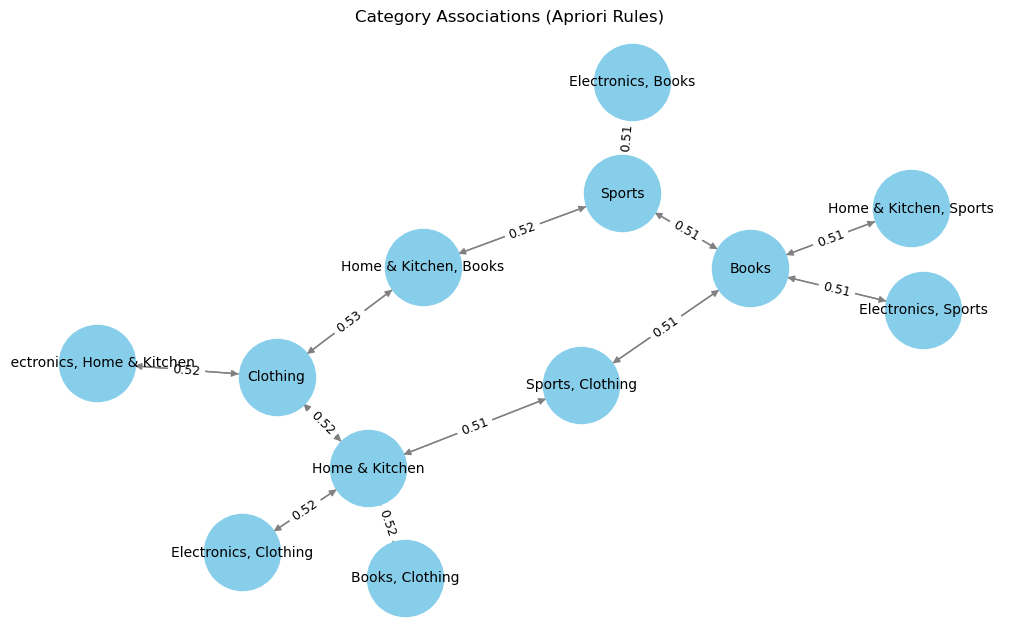

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in filtered_rules.iterrows():
    antecedent = ", ".join(row["antecedents"])
    consequent = ", ".join(row["consequents"])
    confidence = row["confidence"]  # Edge weight
    
    G.add_edge(antecedent, consequent, weight=confidence)

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Layout for better spacing
edges = G.edges(data=True)

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=3000, font_size=10)
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Category Associations (Apriori Rules)")
plt.show()


Get combinations of >=3

In [42]:
# Extract associations with 3 or more categories
associated_categories = []

for _, row in filtered_rules.iterrows():
    category_set = list(row["antecedents"]) + list(row["consequents"])
    
    # Only include sets with 3 or more categories
    if len(category_set) >= 3:
        associated_categories.append(category_set)

# Display the list of category associations
print(associated_categories)


[['Home & Kitchen', 'Sports', 'Books'], ['Home & Kitchen', 'Books', 'Sports'], ['Sports', 'Home & Kitchen', 'Books'], ['Books', 'Home & Kitchen', 'Sports'], ['Sports', 'Clothing', 'Books'], ['Books', 'Sports', 'Clothing'], ['Electronics', 'Sports', 'Books'], ['Electronics', 'Books', 'Sports'], ['Sports', 'Electronics', 'Books'], ['Books', 'Electronics', 'Sports'], ['Sports', 'Clothing', 'Home & Kitchen'], ['Home & Kitchen', 'Sports', 'Clothing'], ['Home & Kitchen', 'Books', 'Clothing'], ['Books', 'Clothing', 'Home & Kitchen'], ['Home & Kitchen', 'Books', 'Clothing'], ['Clothing', 'Home & Kitchen', 'Books'], ['Electronics', 'Home & Kitchen', 'Clothing'], ['Electronics', 'Clothing', 'Home & Kitchen'], ['Home & Kitchen', 'Electronics', 'Clothing'], ['Clothing', 'Electronics', 'Home & Kitchen']]


In [43]:
# Extract associations with 3 or more categories, avoiding repetitions
unique_associations = set()

for _, row in filtered_rules.iterrows():
    category_set = frozenset(row["antecedents"]) | frozenset(row["consequents"])  # Merge both sets
    
    # Only include sets with 3 or more categories
    if len(category_set) >= 3:
        unique_associations.add(category_set)  # Add as a frozenset to ensure uniqueness

# Convert to a list for easier readability
final_associations = [list(assoc) for assoc in unique_associations]

# Display the unique list of category associations
print(final_associations)


[['Electronics', 'Sports', 'Books'], ['Electronics', 'Home & Kitchen', 'Clothing'], ['Home & Kitchen', 'Books', 'Clothing'], ['Home & Kitchen', 'Sports', 'Books'], ['Books', 'Sports', 'Clothing'], ['Home & Kitchen', 'Sports', 'Clothing']]


In [44]:
print(len(final_associations))

6


We get 3 commonly bought categories.
For a more diverse and real dataset, we could do this for products too.